# 10. 나를 찾아줘 - Class Activation Map 만들기  
## 10-1. 들어가며  
<img src="결과.png">  
이번시간에는 기본 CAM과 Grad-CAM을 구현해보고 이를 시각화해보자.  
그리고 CAM을 활용하여 물체의 위치를 찾는 object detection을 수행하고 이를 정답데이터와 비교해보자  

### 실습목표  
---------------------------
  1. Classification model로부터 CAM을 얻어낼 수 있다.
  2. CAM으로 물체의 위치를 찾을 수 있다.
  3. CAM을 시각화 비교할 수 있다.  
  
### 학습 내용  
---------------------------------------
  1. CAM, Grad-CAM용 모델 준비하기
  2. CAM
  3. Grad-CAM
  4. Detection with CAM

### 준비물
---------------------------------------
실습환경에 맞게 경로를 수정, 터미널을 열고 디렉토리를 만들자.  
```
$ mkdir -p ~/aiffel/class_activation_map
```


## 10-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기  

CAM(Class Activation Map)은 특성 추출하는 CNN 뒤에 GAP(Global Average Pooling)과 소프트맥스레이어(softmax layer)가 붙어야 한다는 제약이 있지만, Grad-CAM은 이런 제약이 없습니다.  
이번시간에 2가지를 다 만들어보는데, 먼저 CAM을 위한 모델부터 구성해 기본적인 CAM을 추출해보고, 이모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출해보자.  
Grad-CAM은 모델 구조에 제약이 없기에 CAM에만 모델을 맞춰도 충분하다.  
CAM은 클래스에 대한 활성화 정도를 나타낸 지도.  
기본적으로 우리의 모델은 분류(classfication)를 수행하는 모델  
우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 한다  
Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요.  여기서는 Cars196 데이터셋을 사용.
196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 바운딩 박스(bounding box) 정보를 포함.  
[cars196](https://www.tensorflow.org/datasets/catalog/cars196)




In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

cars196 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어있습니다.  
tfds.load()를 활용해서 데이터셋을 다운로드 해주세요.  
(주의) 아래 데이터셋은 총 사이즈 1.8GB에 이르는 대용량 데이터셋입니다.
최초로 load()를 호출하는 경우 다운로드에 1시간 가량 소요될 수 있으므로, 최초 다운로드는 jupyter notebook을 통해 수행하시기를 권합니다.

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

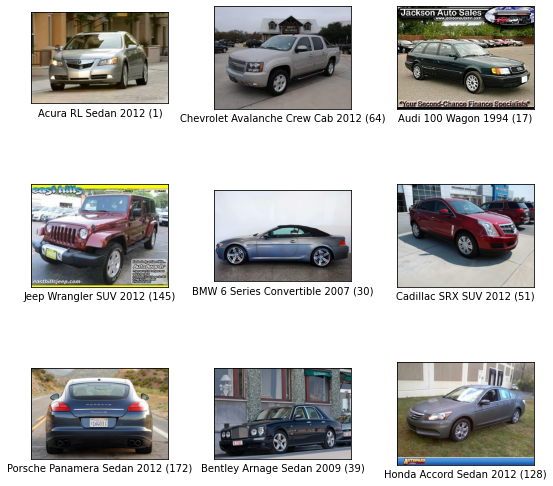

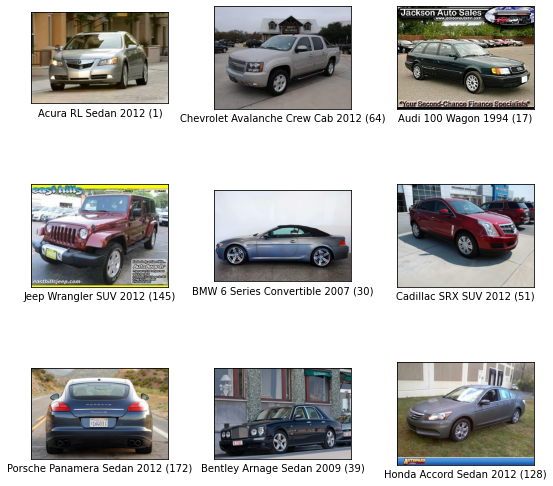

In [4]:
tfds.show_examples(ds_train, ds_info)

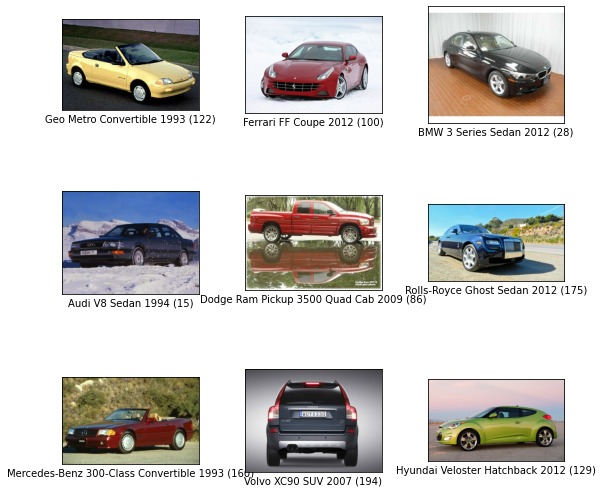

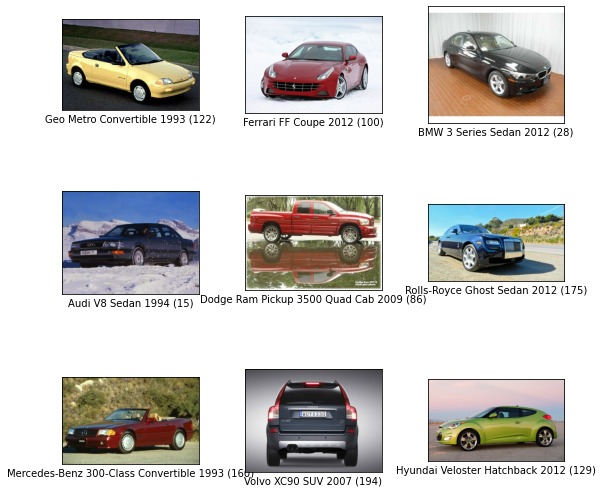

In [5]:
tfds.show_examples(ds_test, ds_info)

## 10-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보  
원본 이미지 위에 물체의 위치정보는 어떻게 시각화하여 표시할 수 있을까요?
데이터셋의 메타정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인해보자.

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

image, label은 입력이미지와 이미지에 해당하는 정답 클래스의 인덱스.  
bbox라는 새로운 키(key)가 있는데 bbox(바운딩박스)는 아래 그림과 같이 물체의 위치를 사각형영역으로 표기
[bbox](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)  
<img src="bbox.jpg">  

바운딩박스를 표시하는 방법.  
바운딩 박스를 라벨링하는 방법은 'xywh', 'minmax'.  
  * 'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.(x_center, y_center, width, height)  
    * x,y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다.
  * 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다. ((x_min, x_max, y_min, y_max)  
    * 좌표의 절댓값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대값을 표기하는 게 일반적.
  * 위의 두가지 말고 LRTB, QUAD법 등이 있다.   


Q1. 주어진 데이터셋에서 BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요?  (참고)로 제시된 텐서플로우 튜토리얼 링크를 통해 확인해 봅시다.  
ANS) 해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미하게 됩니다.  

## 10-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기  
본격적으로 CAM을 얻어내기 위한 모델을 만들어보자.  
이번에는 imagenet에 미리 훈련된 resnet50을 기반으로 활용하고, pooling layer뒤에 소프트맥스 레이어를 붙여 Grad-CAM모델을 만들겠습니다.  
참고로 소프트맥스 레이어는 소프트맥스 함수를 활성화함수로 사용하는 Fully Connected Layer입니다  
**구현해보기**  
아래에 resnet50 뒤에 필요한 레이어를 CAM을 구하기 위한 기본 모델을 완성하자.  
CAM구조가 생각나지 않으면 관련 노드나 강좌를 참고하자.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

CAM모델은 우리가 기존에 해왔던 분류문제를 위한 모델과 크게 다르지 않다. 다른 점은 마지막 fully connected layer대신 GAP을 사용해준다.  
우리의 경우 keras.application의 ResNet50의 매개변수 pooling에 avg를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.  
[ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)  

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

Q2. CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.  
ANS) conv5_block3_out의 output이 feature map이 됩니다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.

## 10-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기  
학습을 위한 과정은 이전과 비슷하다.  
학습, 검증 데이터에 normalizing, resizing은 normalize_and_resize_img()로 실시하고, 이것을 포함해서 apply_normalize_on_dataset()에서 배치를 구성.  
이전 input과 다르게 bbox정보가 포함되어 있지만, 지금 CAM학습에 있어서는 필요없기에 normalize_and_resize_img에서 제외한다.  
CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box와 같이 직접적인 라벨을 사용하지 않고, weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식.

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
  2/509 [..............................] - ETA: 34s - loss: 5.6380 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0514s vs `on_train_batch_end` time: 0.0814s). Check your callbacks.


509/509 [==============================] - 85s 166ms/step - loss: 4.1155 - accuracy: 0.1761 - val_loss: 5.4652 - val_accuracy: 0.0056
Epoch 2/15
509/509 [==============================] - 84s 165ms/step - loss: 1.6302 - accuracy: 0.6504 - val_loss: 1.9041 - val_accuracy: 0.5082
Epoch 3/15
509/509 [==============================] - 87s 170ms/step - loss: 0.5519 - accuracy: 0.9063 - val_loss: 1.2033 - val_accuracy: 0.6795
Epoch 4/15
509/509 [==============================] - 86s 169ms/step - loss: 0.1670 - accuracy: 0.9835 - val_loss: 1.0574 - val_accuracy: 0.7188
Epoch 5/15
509/509 [==============================] - 84s 165ms/step - loss: 0.0716 - accuracy: 0.9969 - val_loss: 1.0111 - val_accuracy: 0.7321
Epoch 6/15
509/509 [==============================] - 84s 166ms/step - loss: 0.0336 - accuracy: 0.9985 - val_loss: 1.0029 - val_accuracy: 0.7281
Epoch 7/15
509/509 [==============================] - 85s 167ms/step - loss: 0.0205 - accuracy: 0.9988 - val_loss: 0.9757 - val_accuracy: 0.7

In [13]:
#학습한 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 10-6. CAM  
이제 학습한 모델을 통해 CAM을 생성할 예정인데, 메모리부족으로 이후 실습에 문제가 생길수 있으니 커널을 재시작하길 권합니다.

In [14]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

학습된 모델에서 CAM을 생성. CAM생성작업은 데이터셋배치단위가 아니라 개별 이미지 단위로 이뤄지므로 get_one()함수를 통해 데이터셋에서 한장씩 뽑을 수 있도록 했습니다.

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

130


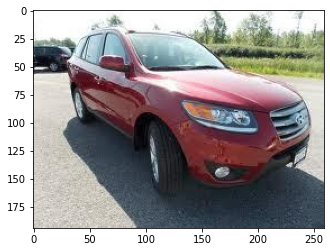

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [17]:
#데이터준비가 끝났으니 이전에 학습시킨 모델을 불러와서 CAM을 생성하자
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 1.특성맵, 2. 클래스별 확률을 얻기 위한 소프트맥스레이어의 가중치, 3. 원하는 클래스의 출력값이 필요.
또한 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기 위해서 네트워크에서 나온 CAM을 입력이미지와 같은 사이즈로 만들어 시각화.  
이를 위해서 model과 item을 받았을 때 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.  

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

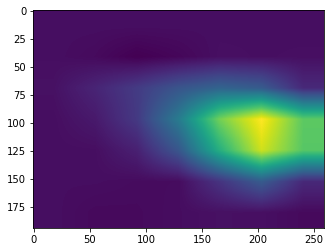

In [19]:
#위의 함수를 실행하면 이와 같은 CAM을 얻을 수 있는데, 생각보다 위치를 정확하게 표현함을 알 수 있다.  
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [20]:
#원본 + CAM  
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

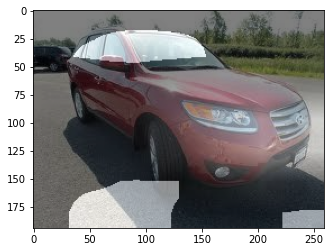

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

생성된 CAM을 보면 주로 차량의 전면 엠블럼을 강조하는 경향이 있는데, 이는 사람이 식별하는 방식과 일맥상통함을 확인할 수 있다.

## 10-7. Grad-CAM  
이번에는 Grad-CAM을 통해 CAM을 얻어보자. 적용모델을 유연하게 선택할 수 있는 Grad-CAM 특성상 위에서 만든 모델을 활용해도 되기에 관찰 대상 모델은 cam_model을 그대로 활용.  
일단 새로운 이미지를 뽑아보자

130


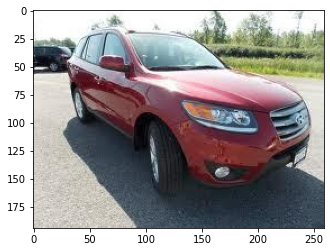

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이번에는 Grad-CAM을 이용해서 CAM을 만들어보자.  
grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP연산을 적용함으로써, 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.  
최종 CAM 이미지를 구하기 위해 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성맵을 가중합하여 cam_image를 얻는다.  
위의 CAM과 달리 Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸수 있도록 activation_layer의 이름을 받고 이를 활용.  
아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 cam_model.summary()에서 찾을 수 있습니다.

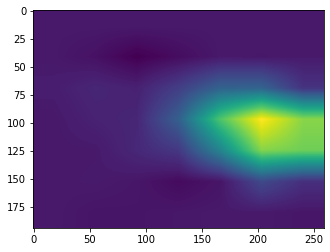

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

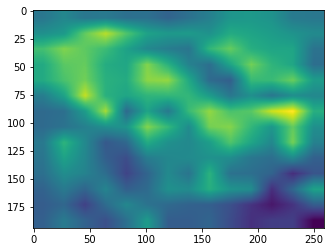

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

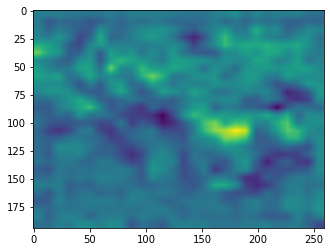

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## 10-8. Detection with CAM  

### 바운딩 박스  
--------------------------------------------------------------
CAM에서 물체의 위치를 찾는 detection을 해보자. 

58


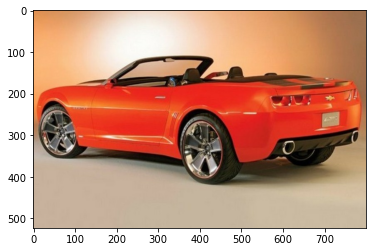

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

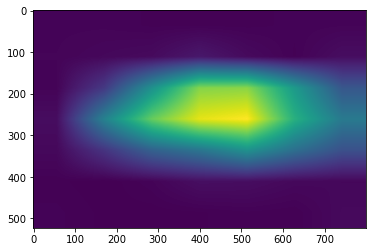

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전 generate_cam을 통해 CAM이미지를 뽑아보자.  
아래 get_bbox()함수는 바운딩 박스를 만들기 위해 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.  
그 다음 OpenCV의 findContours(), minAreaRect()로 사각형을 찾는다.  
이 때 rotated_rect라는 회전된 바운딩 박슬르 얻는데, boxPoints()로 이를 꼭짓점으로 바꿔준다.  
마지막에 int자료형으로 변환

In [31]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [32]:
#cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 62, 402],
       [ 65,  97],
       [802, 105],
       [798, 410]])

In [33]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 62, 402],
       [ 65,  97],
       [802, 105],
       [798, 410]])

## Intersection Over Union  
-----------------------------------------------------------
위의 CAM과 Grad-CAM 두가지 방법을 통해 얻은 바운딩 박스가 있는데, 정답데이터인 바운딩 박스와 이를 비교할 때 어떻게 할까?  
<img src="IoU.jpg">  
IoU(intersection over union)는 두 영역의 합집합인 union으로 교집합영역인 intersection을 나눠준 값.  
이를 통해 물건의 절대적인 면적과 상관없이 상대적인 비율을 구할 수 있어 비교하기 좋은 지표다.  
[참고](https://www.youtube.com/watch?v=ANIzQ5G-XPE)  

In [34]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [35]:
#위에서 구한 rect를 minmax bbox로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.18546845124282982, 0.0775, 0.7839388145315488, 1.0025]

In [36]:
#ground truth bbox를 확인
item['bbox']

array([0.19694072, 0.00625   , 0.8126195 , 0.99125   ], dtype=float32)

In [37]:
#CAM을 통해 얻은 bbox가 ground truth bbox와 얼마나 유사한지 IoU를 계산해보자  
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [38]:
get_iou(pred_bbox, item['bbox'])

0.8600362485505011

## 10-9. 프로젝트: CAM을 만들고 평가해보자  
----------------------------------------------
### CAM 구현하기  
-------------------------------------------
1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```

CAM을 생성하기 위해서는 1.특성맵, 2. 클래스별 확률을 얻기 위한 소프트맥스레이어의 가중치, 3. 원하는 클래스의 출력값이 필요.
또한 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기 위해서 네트워크에서 나온 CAM을 입력이미지와 같은 사이즈로 만들어 시각화.  
이를 위해서 model과 item을 받았을 때 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.  

In [ ]:
def generate_cam(model, item):
    # CAM의 사이즈를 위해 입력이미지 사이즈.
    width = item.shape[0]
    height = item.shape[1]
    img, label = normalized_and_resize_img(item)
    #feature까지 
    model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    cam_image = None
    # TODO: generate cam image
    return cam_image

2) 만든 함수로 CAM 이미지를 생성합시다.
```
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요. [블렌딩](https://webnautes.tistory.com/1245)
```
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image
```
```
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

### Grad-CAM 구현하기  
---------------------------------------
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
```
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

### 바운딩 박스 구하기
--------------------------------------------------------------------------------
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

### IoU 구하기  
----------------------------------------------------------------------
1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.
```
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.